In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time, warnings
import datetime as dt

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

##Get The Data

In [2]:
#load the dataset

superstore_df = pd.read_excel('Sample - Superstore.xls')

superstore_df.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2018-152156 2018-11-08 2018-11-11    Second Class    CG-12520   
1       2  CA-2018-152156 2018-11-08 2018-11-11    Second Class    CG-12520   
2       3  CA-2018-138688 2018-06-12 2018-06-16    Second Class    DV-13045   
3       4  US-2017-108966 2017-10-11 2017-10-18  Standard Class    SO-20335   
4       5  US-2017-108966 2017-10-11 2017-10-18  Standard Class    SO-20335   

     Customer Name    Segment Country/Region             City  ...  \
0      Claire Gute   Consumer  United States        Henderson  ...   
1      Claire Gute   Consumer  United States        Henderson  ...   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...   

  Postal Code  Region       Product ID         Category Sub-Category  \
0     42420.0   South  FUR-BO-10001798        Furniture    Bookcases   
1     42420.0   South  FUR-CH-10000454        Furniture       Chairs   
2     90036.0    West  OFF-LA-10000240  Office Supplies       Labels   
3     33311.0   South  FUR-TA-10000577        Furniture       Tables   
4     33311.0   South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600         2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400         3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200         2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775         5   
4                     Eldon Fold 'N Roll Cart System   22.3680         2   

   Discount    Profit  
0      0.00   41.9136  
1      0.00  219.5820  
2      0.00    6.8714  
3      0.45 -383.0310  
4      0.20    2.5164  

[5 rows x 21 columns]

In [3]:
superstore_df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country/Region', 'City',
       'State', 'Postal Code', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit'],
      dtype='object')

In [4]:
print(superstore_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          9994 non-null   int64         
 1   Order ID        9994 non-null   object        
 2   Order Date      9994 non-null   datetime64[ns]
 3   Ship Date       9994 non-null   datetime64[ns]
 4   Ship Mode       9994 non-null   object        
 5   Customer ID     9994 non-null   object        
 6   Customer Name   9994 non-null   object        
 7   Segment         9994 non-null   object        
 8   Country/Region  9994 non-null   object        
 9   City            9994 non-null   object        
 10  State           9994 non-null   object        
 11  Postal Code     9983 non-null   float64       
 12  Region          9994 non-null   object        
 13  Product ID      9994 non-null   object        
 14  Category        9994 non-null   object        
 15  Sub-

#⛑ Prepare data

As customer clusters may vary by geography,from that we can see the state that have most sales is in **California**


In [5]:
# sales = superstore_df[superstore_df['State']=='California']
sales = superstore_df.copy()

#check the shape
sales.shape

(9994, 21)

In [6]:
sales = sales[sales['Quantity']>0]
sales.shape
#the same shape as before so we can assume no canceled order

(9994, 21)

In [7]:
#remove rows where customerID are NA
sales.dropna(subset=['Customer ID'],how='all',inplace=True)
sales.shape
#no empty customer id too

(9994, 21)

In [8]:
sales['Order Date'] = pd.to_datetime(sales['Order Date'], format='%m/%d/%Y')

sales['Order Date'].dt.year.value_counts()

Order Date
2019    3312
2018    2587
2017    2102
2016    1993
Name: count, dtype: int64

In [9]:
print("Summary..")
#exploring the unique values of each attribute
print("Number of transactions: ", sales['Order ID'].nunique())
print("Number of products bought: ",sales['Quantity'].nunique())
print("Number of customers:", sales['Customer ID'].nunique() )
print("Percentage of customers NA: ", round(sales['Customer ID'].isnull().sum() * 100 / len(superstore_df),2),"%" )

Summary..
Number of transactions:  5009
Number of products bought:  14
Number of customers: 793
Percentage of customers NA:  0.0 %


In [10]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          9994 non-null   int64         
 1   Order ID        9994 non-null   object        
 2   Order Date      9994 non-null   datetime64[ns]
 3   Ship Date       9994 non-null   datetime64[ns]
 4   Ship Mode       9994 non-null   object        
 5   Customer ID     9994 non-null   object        
 6   Customer Name   9994 non-null   object        
 7   Segment         9994 non-null   object        
 8   Country/Region  9994 non-null   object        
 9   City            9994 non-null   object        
 10  State           9994 non-null   object        
 11  Postal Code     9983 non-null   float64       
 12  Region          9994 non-null   object        
 13  Product ID      9994 non-null   object        
 14  Category        9994 non-null   object        
 15  Sub-

#RFM Analysis

**RFM** (Recency, Frequency, Monetary) analysis is a customer segmentation technique that uses past purchase behavior to divide customers into groups.
RFM helps divide customers into various categories or clusters to identify customers who are more likely to respond to promotions and also for future personalization services.

- RECENCY (R): Days since last purchase
- FREQUENCY (F): Total number of purchases
- MONETARY VALUE (M): Total money this customer spent.

We will create those 3 customer attributes for each customer.

##Recency


 we need to choose a date point from which we **how many days ago** was the customer's last purchase.

In [11]:
#last date available in our dataset
sales['Order Date'].max()

Timestamp('2019-12-30 00:00:00')

in this scenario the team analyze in 2021-01-01, we use this as reffrence

In [12]:
now = dt.date(2019,12,30)
print(now)

2019-12-30


In [13]:
#create a new column called date which contains the date of invoice only
sales['date'] = pd.DatetimeIndex(sales['Order Date']).date
sales.head()

Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0       1  CA-2018-152156 2018-11-08 2018-11-11    Second Class    CG-12520   
1       2  CA-2018-152156 2018-11-08 2018-11-11    Second Class    CG-12520   
2       3  CA-2018-138688 2018-06-12 2018-06-16    Second Class    DV-13045   
3       4  US-2017-108966 2017-10-11 2017-10-18  Standard Class    SO-20335   
4       5  US-2017-108966 2017-10-11 2017-10-18  Standard Class    SO-20335   

     Customer Name    Segment Country/Region             City  ... Region  \
0      Claire Gute   Consumer  United States        Henderson  ...  South   
1      Claire Gute   Consumer  United States        Henderson  ...  South   
2  Darrin Van Huff  Corporate  United States      Los Angeles  ...   West   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...  South   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale  ...  South   

        Product ID         Category Sub-Category  \
0  FUR-BO-10001798        Furniture    Bookcases   
1  FUR-CH-10000454        Furniture       Chairs   
2  OFF-LA-10000240  Office Supplies       Labels   
3  FUR-TA-10000577        Furniture       Tables   
4  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales Quantity  \
0                  Bush Somerset Collection Bookcase  261.9600        2   
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400        3   
2  Self-Adhesive Address Labels for Typewriters b...   14.6200        2   
3      Bretford CR4500 Series Slim Rectangular Table  957.5775        5   
4                     Eldon Fold 'N Roll Cart System   22.3680        2   

   Discount    Profit        date  
0      0.00   41.9136  2018-11-08  
1      0.00  219.5820  2018-11-08  
2      0.00    6.8714  2018-06-12  
3      0.45 -383.0310  2017-10-11  
4      0.20    2.5164  2017-10-11  

[5 rows x 22 columns]

In [14]:
#group by customers and check last date of purshace
recency_df = sales.groupby(by='Customer ID', as_index=False)['date'].max()
recency_df.columns = ['Customer ID','LastPurchaseDate']
recency_df.head()

Customer ID LastPurchaseDate
0    AA-10315       2019-06-29
1    AA-10375       2019-12-11
2    AA-10480       2019-04-15
3    AA-10645       2019-11-05
4    AB-10015       2018-11-10

In [15]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)
recency_df.head()

Customer ID LastPurchaseDate  Recency
0    AA-10315       2019-06-29      184
1    AA-10375       2019-12-11       19
2    AA-10480       2019-04-15      259
3    AA-10645       2019-11-05       55
4    AB-10015       2018-11-10      415

In [16]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurchaseDate',axis=1,inplace=True)
recency_df.head()

Customer ID  Recency
0    AA-10315      184
1    AA-10375       19
2    AA-10480      259
3    AA-10645       55
4    AB-10015      415

##Frequency

Frequency helps us to know how many times a customer purchased from us. To do that we need to check how many invoices are registered by the same customer.

In [17]:
# drop duplicates
sales_copy = sales
sales_copy.drop_duplicates(subset=['Order Date', 'Customer ID'], keep="first", inplace=True)
#calculate frequency of purchases
frequency_df = sales_copy.groupby(by=['Customer ID'], as_index=False)['Order Date'].count()
frequency_df.columns = ['Customer ID','Frequency']

# Sort the dataframe by the "Frequency" column in descending order
frequency_df = frequency_df.sort_values(by='Frequency', ascending=False)

frequency_df.head()

Customer ID  Frequency
275    EP-13915         17
691    SH-19975         13
791    ZC-21910         13
591    PG-18820         13
147    CK-12205         13

##Monetary

Monetary attribute answers the question: **How much money did the customer spent over time?**

To do that, first, we will create a new column total revenue, since we already have sales we need to do nothing but just club the amount

In [18]:
#i use this to confirm the calculation is right/not
#monetary_df = sales.groupby(by='Customer ID', as_index=False).agg({'TotalCost': 'sum', 'Quantity': 'sum','Sales': 'sum'})

# Group by "Customer ID" and aggregate the sum of "TotalCost" and "Quantity" for each customer
monetary_df = sales.groupby(by='Customer ID', as_index=False).agg({'Sales': 'sum'})

# Rename columns
monetary_df.columns = ['Customer ID', 'Monetary']

# Sort the DataFrame by Monetary value in descending order
#monetary_df = monetary_df.sort_values(by='Monetary', ascending=False)
monetary_df.head()

Customer ID  Monetary
0    AA-10315  5008.480
1    AA-10375   718.000
2    AA-10480    76.502
3    AA-10645  1064.158
4    AB-10015   283.316

In [19]:
sorted_monetary_df = monetary_df.sort_values('Monetary', ascending=False)
print(sorted_monetary_df.head())

    Customer ID   Monetary
6      AB-10105  12120.595
327    HL-15040  11713.828
730    TA-21385  11649.210
683    SE-20110  10639.654
104    BS-11365  10351.023


##Combine

In [20]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='Customer ID')
temp_df.head()

Customer ID  Recency  Frequency
0    AA-10315      184          5
1    AA-10375       19          9
2    AA-10480      259          4
3    AA-10645       55          6
4    AB-10015      415          3

In [21]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='Customer ID')
#use CustomerID as index
rfm_df.set_index('Customer ID',inplace=True)
#check the head
rfm_df.head()

Recency  Frequency  Monetary
Customer ID                              
AA-10315         184          5  5008.480
AA-10375          19          9   718.000
AA-10480         259          4    76.502
AA-10645          55          6  1064.158
AB-10015         415          3   283.316

## Customer segments with RFM Model

The simplest way to create customers segments from RFM Model is to use ** Tertiles**. We assign a score from 1 to 3 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [22]:
tertiles = rfm_df.quantile(q=[0.33,0.66])

In [23]:
tertiles.to_dict()

{'Recency': {0.33: 41.0, 0.66: 119.0},
 'Frequency': {0.33: 5.0, 0.66: 7.0},
 'Monetary': {0.33: 605.27416, 0.66: 1414.6674400000002}}

### Creation of RFM Segments

choose how to target or deal with each segment.

For example:

**Best Customers - Champions**: Reward them. They can be early adopters to new products. Suggest them "Refer a friend".

In [24]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = tertiles dict)
def RScore(x,p,d):
    if x <= d[p][0.33]:
        return 3
    elif x <= d[p][0.66]:
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = tertiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.33]:
        return 1
    elif x <= d[p][0.66]:
        return 2
    else:
        return 3

In [25]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Tertile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',tertiles,))
rfm_segmentation['F_Tertile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',tertiles,))
rfm_segmentation['M_Tertile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',tertiles,))

In [26]:
rfm_segmentation['RFM_Score'] = rfm_segmentation.R_Tertile.map(str) \
                            + rfm_segmentation.F_Tertile.map(str) \
                            + rfm_segmentation.M_Tertile.map(str)
rfm_segmentation.head()

Recency  Frequency  Monetary  R_Tertile  F_Tertile  M_Tertile  \
Customer ID                                                                  
AA-10315         184          5  5008.480          1          1          3   
AA-10375          19          9   718.000          3          3          2   
AA-10480         259          4    76.502          1          1          1   
AA-10645          55          6  1064.158          2          2          2   
AB-10015         415          3   283.316          1          1          1   

            RFM_Score  
Customer ID            
AA-10315          113  
AA-10375          332  
AA-10480          111  
AA-10645          222  
AB-10015          111

In [27]:
import requests
from io import StringIO

In [28]:
segment_name = {'112':'ABOUT TO SLEEP',
                '113':'ABOUT TO SLEEP',
                '121':'ABOUT TO SLEEP',

                '122':'ABOUT TO SLEEP',
                '131':'ABOUT TO SLEEP',
                '211':'ABOUT TO SLEEP',

                '212':'ABOUT TO SLEEP',
                '221':'ABOUT TO SLEEP',

                '311':'RECENT CUSTOMER',
                '312':'RECENT CUSTOMER',
                '313':'RECENT CUSTOMER',

                '123':'CANNOT LOOSE THEM',
                '132':'CANNOT LOOSE THEM',
                '133':'CANNOT LOOSE THEM',

                '333':'CHAMPION',
                '111':'LOST CUSTOMER',

                '233':'LOYAL',
                '323':'LOYAL',
                '332':'LOYAL',

                '223':'POTENTIAL LOYALIST',
                '223':'POTENTIAL LOYALIST',
                '322':'POTENTIAL LOYALIST',
                '331':'POTENTIAL LOYALIST',

                '213':'AVERAGE',
                '222':'AVERAGE',
                '231':'AVERAGE',
                '321':'AVERAGE'}

In [29]:
rfm_segmentation["segment_name"] = rfm_segmentation["RFM_Score"].map(segment_name)

In [30]:
rfm_segmentation.head()

Recency  Frequency  Monetary  R_Tertile  F_Tertile  M_Tertile  \
Customer ID                                                                  
AA-10315         184          5  5008.480          1          1          3   
AA-10375          19          9   718.000          3          3          2   
AA-10480         259          4    76.502          1          1          1   
AA-10645          55          6  1064.158          2          2          2   
AB-10015         415          3   283.316          1          1          1   

            RFM_Score    segment_name  
Customer ID                            
AA-10315          113  ABOUT TO SLEEP  
AA-10375          332           LOYAL  
AA-10480          111   LOST CUSTOMER  
AA-10645          222         AVERAGE  
AB-10015          111   LOST CUSTOMER

In [31]:
rfm_segmentation[['segment_name']].value_counts()

segment_name      
ABOUT TO SLEEP        203
LOYAL                 115
LOST CUSTOMER          97
POTENTIAL LOYALIST     78
RECENT CUSTOMER        73
CANNOT LOOSE THEM      68
AVERAGE                67
CHAMPION               62
Name: count, dtype: int64

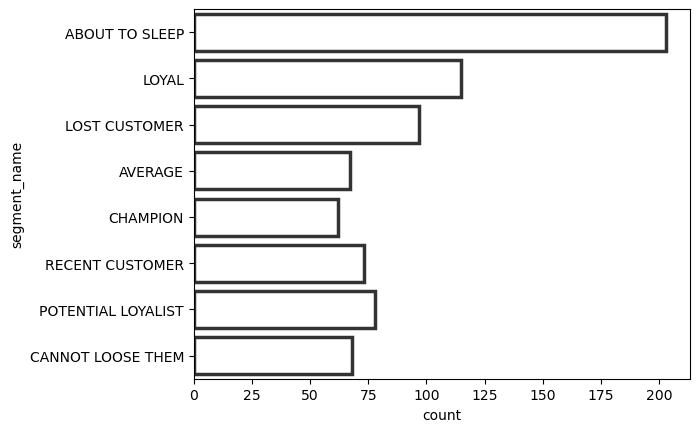

In [32]:
#customer/segments
ax = sns.countplot(y="segment_name", data=rfm_segmentation, linewidth=2.5, facecolor=(1, 1, 1, 0), edgecolor=".2")

In [33]:
rfm_segmentation.groupby('segment_name')['Monetary'].sum()

segment_name
ABOUT TO SLEEP        173528.4159
AVERAGE               100712.8218
CANNOT LOOSE THEM     147542.9220
CHAMPION              183704.3298
LOST CUSTOMER          21914.8130
LOYAL                 251623.6699
POTENTIAL LOYALIST    128632.0583
RECENT CUSTOMER        57442.4430
Name: Monetary, dtype: float64

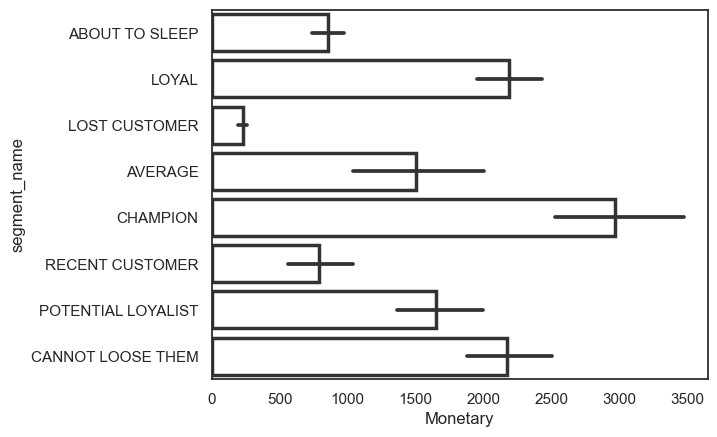

In [34]:
#melihat dgn monetary untk menentukan mana yg mau diprioritaskan
#set seaborn plotting aesthetics
sns.set(style='white')

sns.barplot(x = "Monetary", y = "segment_name", data = rfm_segmentation ,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")

plt.show()

*The line in the middle of the bar shows us how confident we are about the average amount of money spent by each group of customers. A short line means we're very sure, and a long line means we're not as sure.*

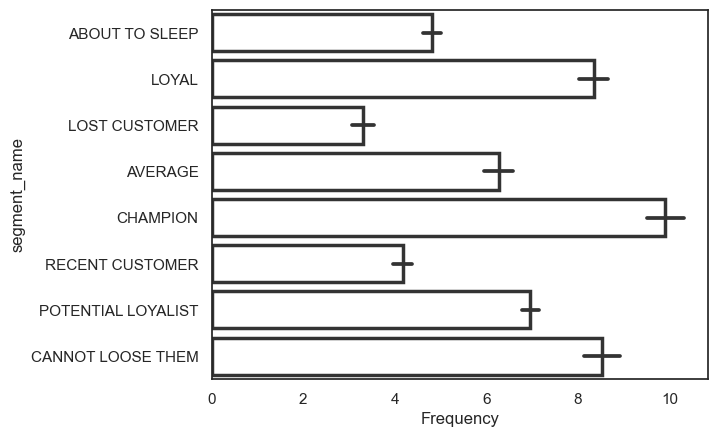

In [35]:
#set seaborn plotting aesthetics
sns.set(style='white')

sns.barplot(x = "Frequency", y = "segment_name", data = rfm_segmentation ,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")

plt.show()

In [36]:
rfm_segmentation.groupby('segment_name')['Frequency'].sum()

segment_name
ABOUT TO SLEEP        975
AVERAGE               420
CANNOT LOOSE THEM     580
CHAMPION              614
LOST CUSTOMER         320
LOYAL                 960
POTENTIAL LOYALIST    542
RECENT CUSTOMER       305
Name: Frequency, dtype: int64

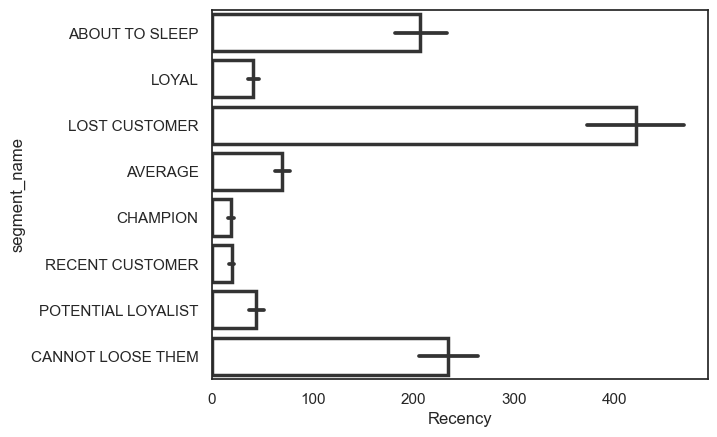

In [37]:
#set seaborn plotting aesthetics
sns.set(style='white')

sns.barplot(x = "Recency", y = "segment_name", data = rfm_segmentation ,linewidth=2.5, facecolor=(1, 1, 1, 0),
                 errcolor=".2", edgecolor=".2")

plt.show()

In [38]:
rfm_segmentation.groupby('segment_name')['Recency'].sum()

segment_name
ABOUT TO SLEEP        41886
AVERAGE                4694
CANNOT LOOSE THEM     15956
CHAMPION               1184
LOST CUSTOMER         40788
LOYAL                  4750
POTENTIAL LOYALIST     3456
RECENT CUSTOMER        1440
Name: Recency, dtype: int64

In [39]:
import plotly.express as px

# Aggregate count of customers per segment
segment_counts = rfm_segmentation.reset_index().groupby(['segment_name']).agg(N_CUST = ('Customer ID' , 'nunique')).reset_index()

# Create the treemap
fig = px.treemap(segment_counts,
                 path=['segment_name'],
                 values='N_CUST',  # Use count of customers as values
                 color='segment_name',
                 title='Customer Segmentation based on RFM Analysis')

# Set layout options
fig.update_layout(
    margin=dict(t=0, l=0, r=0, b=0),
    height=600,
    width=800,
    showlegend=True
)

# Show the treemap
fig.show()


In [66]:
attribute = ['Monetary','Frequency','Recency']

rfm_segmentation.groupby('segment_name')[attribute].describe().transpose()

segment_name     ABOUT TO SLEEP       AVERAGE  CANNOT LOOSE THEM  \
Monetary  count      203.000000     67.000000          68.000000   
          mean       854.819783   1503.176445        2169.748853   
          std        913.609253   2036.847323        1297.861880   
          min         22.210000     76.546000         608.590000   
          25%        373.799000    482.701000        1182.216000   
          50%        702.490000    946.352000        1904.335000   
          75%       1110.886500   1386.593500        2601.645250   
          max      10351.023000  11649.210000        7291.958000   
Frequency count      203.000000     67.000000          68.000000   
          mean         4.802956      6.268657           8.529412   
          std          1.342597      1.431063           1.723157   
          min          1.000000      2.000000           6.000000   
          25%          4.000000      6.000000           7.000000   
          50%          5.000000      6.000000           8.000000   
          75%          6.000000      7.000000           9.000000   
          max          8.000000     10.000000          13.000000   
Recency   count      203.000000     67.000000          68.000000   
          mean       206.334975     70.059701         234.647059   
          std        186.081309     32.082224         126.464173   
          min         42.000000      4.000000         120.000000   
          25%         76.000000     43.000000         152.750000   
          50%        119.000000     69.000000         186.500000   
          75%        283.500000     98.000000         275.750000   
          max       1034.000000    119.000000         718.000000   

segment_name         CHAMPION  LOST CUSTOMER        LOYAL  POTENTIAL LOYALIST  \
Monetary  count     62.000000      97.000000   115.000000           78.000000   
          mean    2962.973061     225.925907  2188.031912         1649.128953   
          std     1942.643812     158.592368  1363.259739         1556.943912   
          min     1447.114000       4.833000   617.646000          337.036000   
          25%     1819.510000      79.750000  1149.942500          765.763500   
          50%     2367.882000     197.640000  1806.710000         1261.470000   
          75%     3238.708000     339.148000  2793.561000         1987.995000   
          max    12120.595000     580.880000  6695.556000        11713.828000   
Frequency count     62.000000      97.000000   115.000000           78.000000   
          mean       9.903226       3.298969     8.347826            6.948718   
          std        1.656677       1.226147     1.711896            0.835844   
          min        8.000000       1.000000     6.000000            6.000000   
          25%        9.000000       2.000000     7.000000            6.000000   
          50%       10.000000       3.000000     8.000000            7.000000   
          75%       11.000000       4.000000     9.000000            7.000000   
          max       17.000000       5.000000    13.000000           10.000000   
Recency   count     62.000000      97.000000   115.000000           78.000000   
          mean      19.096774     420.494845    41.304348           44.307692   
          std       12.098922     244.268471    29.306958           32.810082   
          min        0.000000     120.000000     1.000000            0.000000   
          25%        7.500000     232.000000    21.000000           21.250000   
          50%       19.500000     362.000000    34.000000           34.000000   
          75%       28.000000     534.000000    53.500000           63.250000   
          max       41.000000    1164.000000   117.000000          119.000000   

segment_name     RECENT CUSTOMER  
Monetary  count        73.000000  
          mean        786.882781  
          std        1045.484941  
          min          16.928000  
          25%         137.777000  
          50%         373.140000  
          75%         908.58

In [ ]:
attributes = ['Recency', 'Frequency', 'Monetary', 'R_Tertile', 'F_Tertile',
       'M_Tertile', 'RFM_Score']

In [57]:
rfm_segmentation.groupby('segment_name')[attributes].describe().transpose()

segment_name     ABOUT TO SLEEP       AVERAGE  CANNOT LOOSE THEM  \
Recency   count      203.000000     67.000000          68.000000   
          mean       206.334975     70.059701         234.647059   
          std        186.081309     32.082224         126.464173   
          min         42.000000      4.000000         120.000000   
          25%         76.000000     43.000000         152.750000   
          50%        119.000000     69.000000         186.500000   
          75%        283.500000     98.000000         275.750000   
          max       1034.000000    119.000000         718.000000   
Frequency count      203.000000     67.000000          68.000000   
          mean         4.802956      6.268657           8.529412   
          std          1.342597      1.431063           1.723157   
          min          1.000000      2.000000           6.000000   
          25%          4.000000      6.000000           7.000000   
          50%          5.000000      6.000000           8.000000   
          75%          6.000000      7.000000           9.000000   
          max          8.000000     10.000000          13.000000   
Monetary  count      203.000000     67.000000          68.000000   
          mean       854.819783   1503.176445        2169.748853   
          std        913.609253   2036.847323        1297.861880   
          min         22.210000     76.546000         608.590000   
          25%        373.799000    482.701000        1182.216000   
          50%        702.490000    946.352000        1904.335000   
          75%       1110.886500   1386.593500        2601.645250   
          max      10351.023000  11649.210000        7291.958000   
R_Tertile count      203.000000     67.000000          68.000000   
          mean         1.502463      2.223881           1.000000   
          std          0.501230      0.419989           0.000000   
          min          1.000000      2.000000           1.000000   
          25%          1.000000      2.000000           1.000000   
          50%          2.000000      2.000000           1.000000   
          75%          2.000000      2.000000           1.000000   
          max          2.000000      3.000000           1.000000   
F_Tertile count      203.000000     67.000000          68.000000   
          mean         1.295567      1.880597           2.691176   
          std          0.478581      0.590900           0.465443   
          min          1.000000      1.000000           2.000000   
          25%          1.000000      2.000000           2.000000   
          50%          1.000000      2.000000           3.000000   
          75%          2.000000      2.000000           3.000000   
          max          3.000000      3.000000           3.000000   
M_Tertile count      203.000000     67.000000          68.000000   
          mean         1.689655      1.895522           2.705882   
          std          0.657961      0.761464           0.459033   
          min          1.000000      1.000000           2.000000   
          25%          1.000000      1.000000           2.000000   
          50%          2.000000      2.000000           3.000000   
          75%          2.000000      2.000000           3.000000   
          max          3.000000      3.000000           3.000000   

segment_name         CHAMPION  LOST CUSTOMER        LOYAL  POTENTIAL LOYALIST  \
Recency   count     62.000000      97.000000   115.000000           78.000000   
          mean      19.096774     420.494845    41.304348           44.307692   
          std       12.098922     244.268471    29.306958           32.810082   
          min        0.000000     120.000000     1.000000            0.000000   
          25%        7.500000     232.000000    21.000000           21.250000   
          50%       19.500000     362.000000    34.000000           34.000000   
          75%       28.000000     534.000000    53.500000           63.250000   
          max      

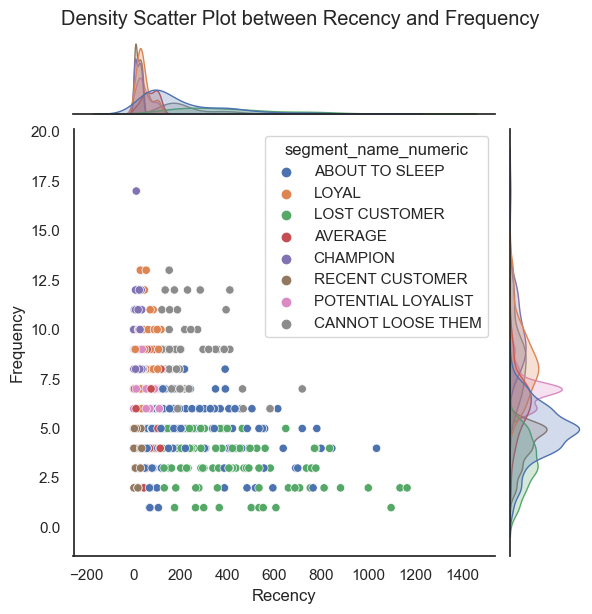

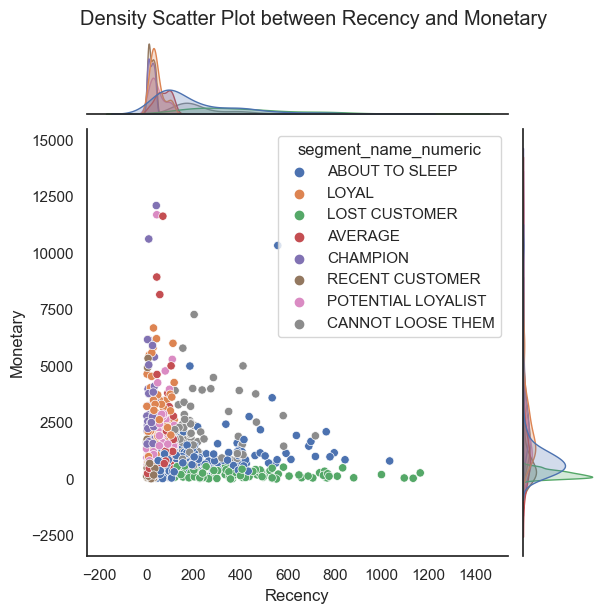

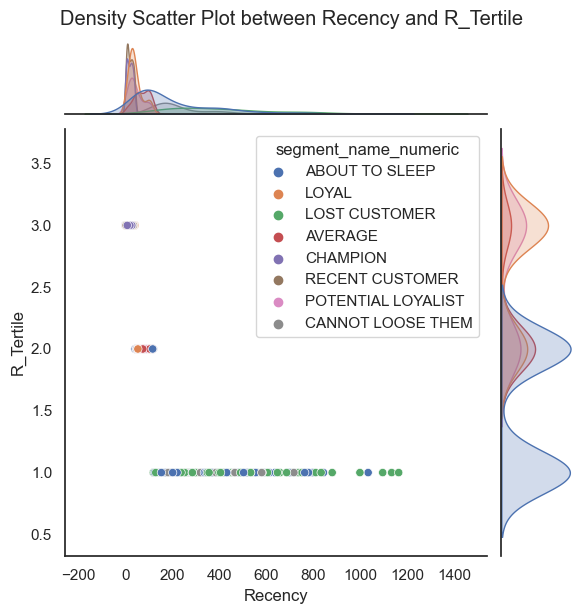

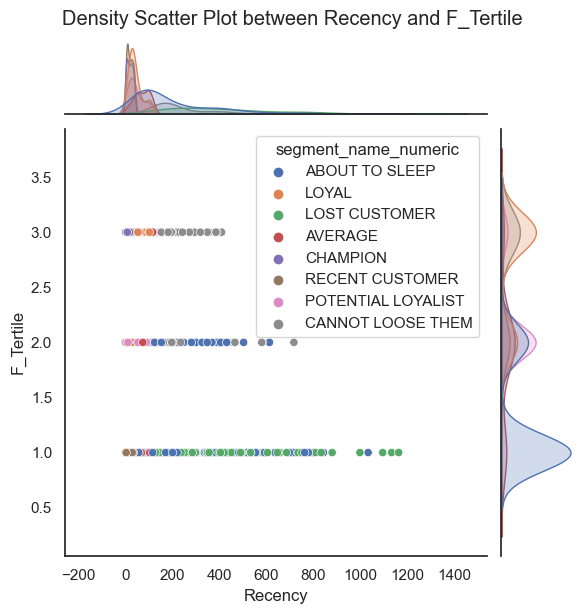

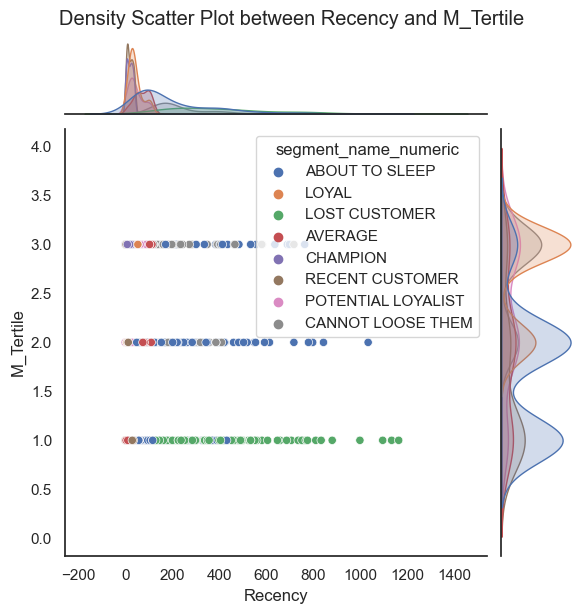

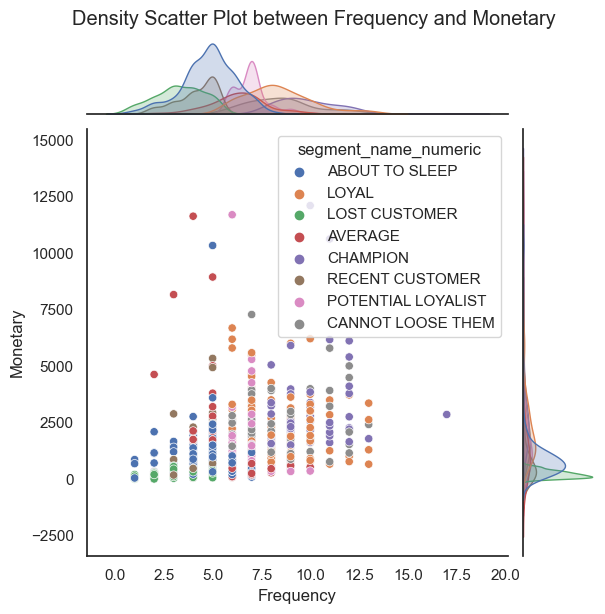

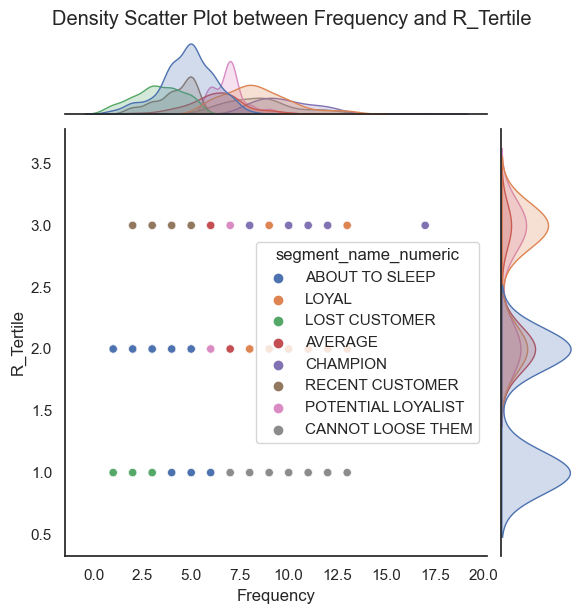

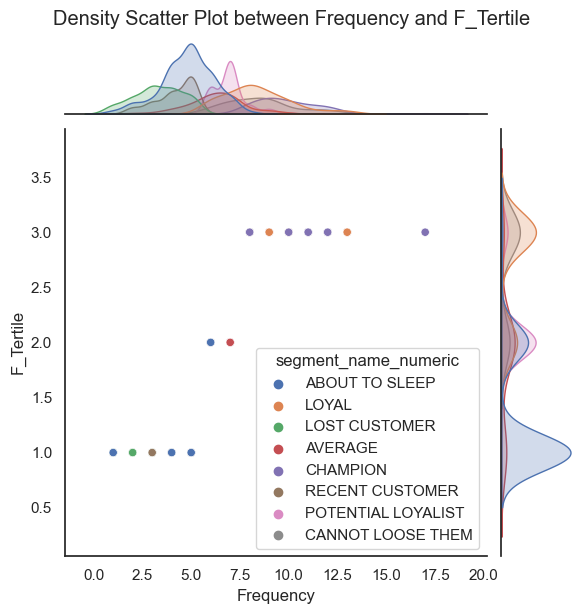

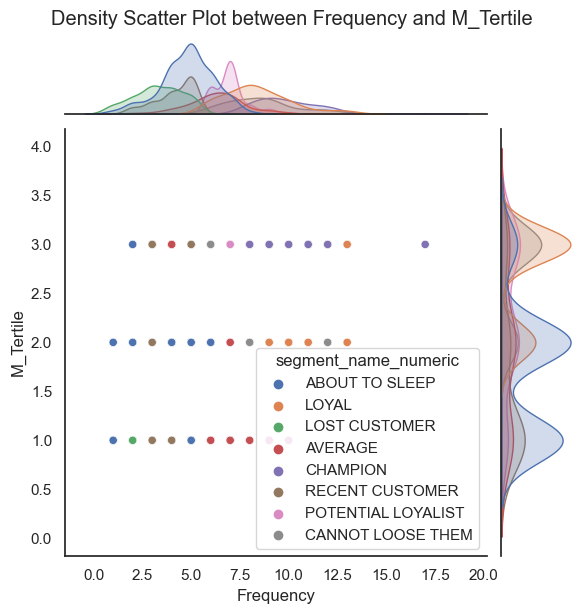

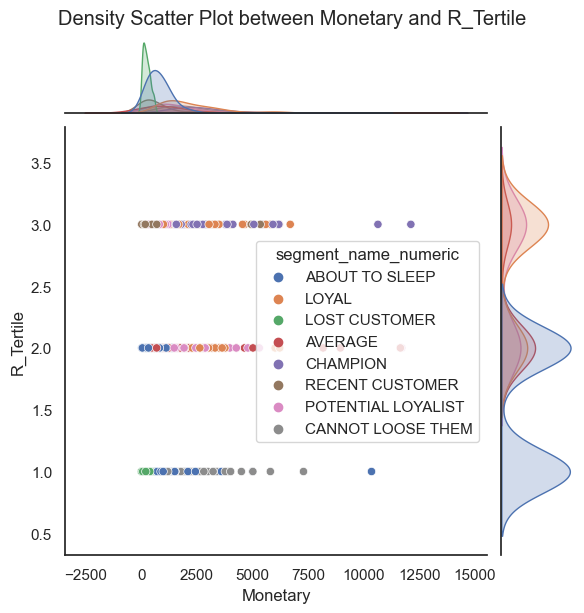

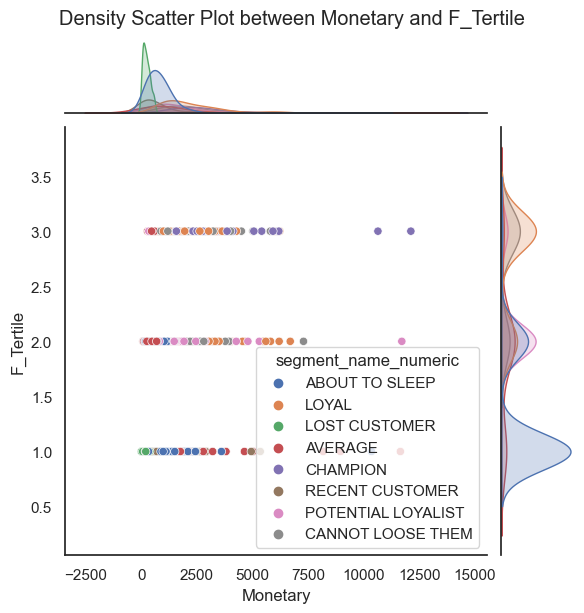

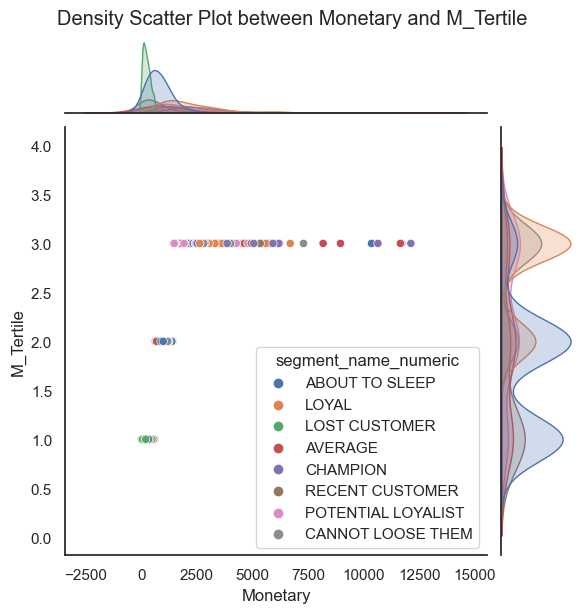

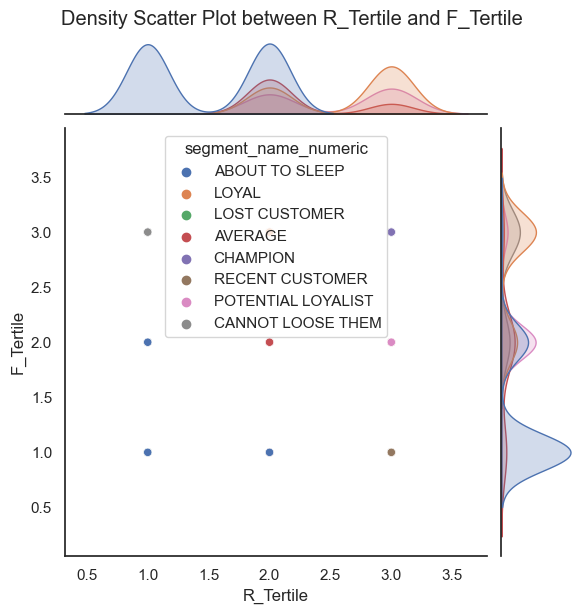

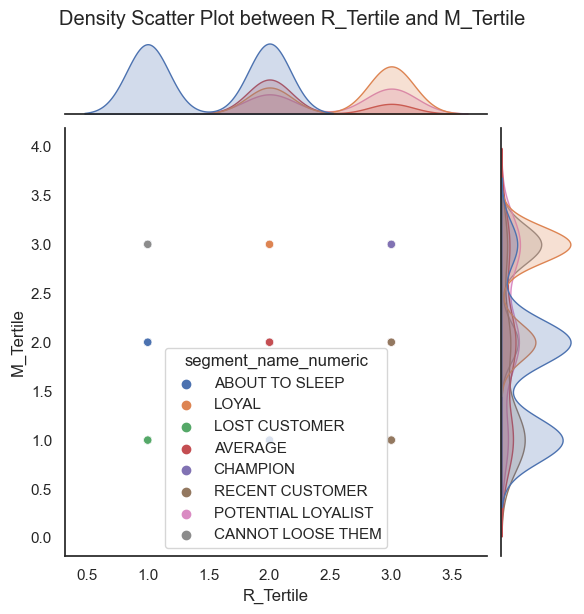

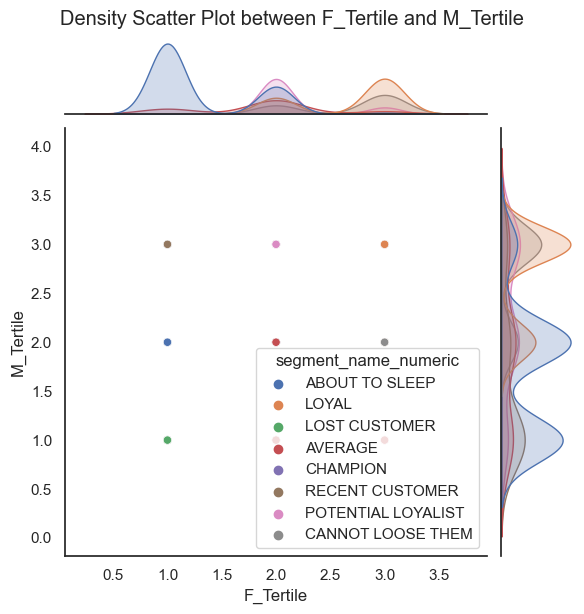

In [64]:
for i, var1 in enumerate(attributes):
    for j, var2 in enumerate(attributes):
        if i < j and not (rfm_segmentation[var1].dtype == 'object' or rfm_segmentation[var2].dtype == 'object'):  # To avoid duplicate plots and exclude categorical variables
            sns.jointplot(x=var1, y=var2, data=rfm_segmentation, kind='scatter', hue='segment_name_numeric')
            plt.suptitle(f'Density Scatter Plot between {var1} and {var2}', y=1.02)
            plt.show()


In [43]:
rfm_segmentation.to_excel('rfm_superstore.xlsx', index=False)

### YOUR FINAL DATA IS **rfm_segmentation**

We need you to create ML based Segments, but be wise what variables should you take forward for clustering?

Your target is to compare the Clusters Created by ML vs the RFM Clusters. Hence you need to interpret ML Clusters Created.

For now you have already done EDA in above cells over R F M Variables. So proceed to implement post EDA Steps for Clustering i.e to create Clusters and explain them, You will use KMeans Algorithm and implement the Best K by Elbow Method and So On

**Marks : Total 35**

- Implement K Means Algorithm (2 Marks)
- Find Best Values of K (2.5 Marks Best Value + 2.5 Marks Explanation of Choice)
- Cluster Prediction and Association to Data (3 Marks)
- Analyziing Clusters with Top Level Statistics (2.5 Marks Values + 2.5 Interpretation)
- Post Clustering EDA of Clusters (10 Marks per detail Analysis of each Variable)
- Finding distribution of RFM based Segments in ML Clusters (10 Marks for Insights)


# INTERPRETATION AND RECOMMENDATIONS

# Detailed interpretation

# COMPARSION Clusters Created by ML vs the RFM Clusters.

In [46]:
rfm_segmentation

Recency  Frequency  Monetary  R_Tertile  F_Tertile  M_Tertile  \
Customer ID                                                                  
AA-10315         184          5  5008.480          1          1          3   
AA-10375          19          9   718.000          3          3          2   
AA-10480         259          4    76.502          1          1          1   
AA-10645          55          6  1064.158          2          2          2   
AB-10015         415          3   283.316          1          1          1   
...              ...        ...       ...        ...        ...        ...   
XP-21865          43         11  1030.072          2          3          2   
YC-21895           4          5  4942.606          3          1          3   
YS-21880           9          8  5059.904          3          3          3   
ZC-21910          54         13  2630.684          2          3          3   
ZD-21925         202          5   981.800          1          1          2   

            RFM_Score     segment_name  
Customer ID                             
AA-10315          113   ABOUT TO SLEEP  
AA-10375          332            LOYAL  
AA-10480          111    LOST CUSTOMER  
AA-10645          222          AVERAGE  
AB-10015          111    LOST CUSTOMER  
...               ...              ...  
XP-21865          232              NaN  
YC-21895          313  RECENT CUSTOMER  
YS-21880          333         CHAMPION  
ZC-21910          233            LOYAL  
ZD-21925          112   ABOUT TO SLEEP  

[793 rows x 8 columns]

In [47]:
rfm_segmentation.to_excel('rfm_superstorecustomerid.xlsx', index=False)

In [71]:
rfm_segmentation.reset_index()

Customer ID  Recency  Frequency  Monetary  R_Tertile  F_Tertile  \
0      AA-10315      184          5  5008.480          1          1   
1      AA-10375       19          9   718.000          3          3   
2      AA-10480      259          4    76.502          1          1   
3      AA-10645       55          6  1064.158          2          2   
4      AB-10015      415          3   283.316          1          1   
..          ...      ...        ...       ...        ...        ...   
788    XP-21865       43         11  1030.072          2          3   
789    YC-21895        4          5  4942.606          3          1   
790    YS-21880        9          8  5059.904          3          3   
791    ZC-21910       54         13  2630.684          2          3   
792    ZD-21925      202          5   981.800          1          1   

     M_Tertile RFM_Score     segment_name segment_name_numeric  
0            3       113   ABOUT TO SLEEP       ABOUT TO SLEEP  
1            2       332            LOYAL                LOYAL  
2            1       111    LOST CUSTOMER        LOST CUSTOMER  
3            2       222          AVERAGE              AVERAGE  
4            1       111    LOST CUSTOMER        LOST CUSTOMER  
..         ...       ...              ...                  ...  
788          2       232              NaN                  NaN  
789          3       313  RECENT CUSTOMER      RECENT CUSTOMER  
790          3       333         CHAMPION             CHAMPION  
791          3       233            LOYAL                LOYAL  
792          2       112   ABOUT TO SLEEP       ABOUT TO SLEEP  

[793 rows x 10 columns]

In [72]:
rfm_segmentation.columns

Index(['Recency', 'Frequency', 'Monetary', 'R_Tertile', 'F_Tertile',
       'M_Tertile', 'RFM_Score', 'segment_name', 'segment_name_numeric'],
      dtype='object')

In [70]:
rfm_segmentation.to_excel('rfm_superstorecustomerid1.xlsx', index=False)